In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# df = pd.read_csv(
#     "S&P500_Close.csv",
#     sep=',',na_values=['-1'], index_col='Date',parse_dates=True)


df = pd.read_csv(
    "rainfall.csv",
    sep=',', index_col='Date',parse_dates=True)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

len(df)

Starting file:
            Precipitation
Date                     
1980-01-01           6.44
1980-01-02          10.76
1980-01-03          18.00
1980-01-04          23.07
1980-01-05          54.90
1980-01-06         193.22
1980-01-07         292.91
1980-01-08         273.94
1980-01-09         123.41
1980-01-10          47.64
Ending file:
            Precipitation
Date                     
2021-01-03          16.57
2021-01-04          26.14
2021-01-05          67.00
2021-01-06         161.84
2021-01-07         309.07
2021-01-08         214.81
2021-01-09         222.42
2021-01-10         106.03
2021-01-11          51.23
2021-01-12          13.92


504

In [12]:
# Test for Stationarity

# ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Call the function and run the test
adf_test(df['Precipitation'])


# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# Call the function and run the test
kpss_test(df['Precipitation'])

Results of Dickey-Fuller Test:
Test Statistic                -5.908686e+00
p-value                        2.670641e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.027019
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [13]:
# Test for non-linearity
# BDS test - output=(array(Test statistic), array(p-value))
# max_dim>=2

from statsmodels.tsa.stattools import bds
bds(df['Precipitation'], max_dim=4, epsilon=0.5) #distance=1.5
bds(df['Precipitation'], max_dim=2, epsilon=1) 
bds(df['Precipitation'], max_dim=2, epsilon=1.5) 
bds(df['Precipitation'], max_dim=2, epsilon=2) 

(array(25.09450087), array(5.71057134e-139))

In [14]:
# Normality of the data
import numpy as np
from scipy import stats
from scipy.stats import shapiro
from numpy.random import randn

# conduct the Shapiro-Wilk Test
Shapiro_Wilks_test=shapiro(df['Precipitation'])
print(Shapiro_Wilks_test)

# conduct the Jarque-Bera Test
jarque_bera_test = stats.jarque_bera(df['Precipitation'])
print(jarque_bera_test)

ShapiroResult(statistic=0.8083075881004333, pvalue=5.2802416523882e-24)
Jarque_beraResult(statistic=88.79657145126833, pvalue=0.0)


In [15]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(df)
# apply transform
normalized = scaler.transform(df)
# inverse transform
# inverse = scaler.inverse_transform(normalized)


In [16]:
# Splitting the data into train and test sets (90% - 10% split)
train_size = int(0.9 * len(df))
df_train = df['Precipitation'][:train_size].values
df_test = df['Precipitation'][train_size:].values

#df_train=normalized[0:1198]
#df_test=normalized[1198:]

spots_train = df_train.tolist()
spots_test = df_test.tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

# #plotting the data
# df_train.plot()
# df_test.plot()

Training set has 453 observations.
Test set has 51 observations.


In [17]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of training set: {}".format(y_train.shape))

print("Shape of test set: {}".format(x_test.shape))
print("Shape of test set: {}".format(y_test.shape))

Shape of training set: (446, 7, 1)
Shape of training set: (446,)
Shape of test set: (44, 7, 1)
Shape of test set: (44,)


Epoch 1/300
6/6 [==============================] - 8s 349ms/step - loss: 20555.1758 - val_loss: 22008.3223
Epoch 2/300
6/6 [==============================] - 1s 217ms/step - loss: 19676.5723 - val_loss: 21312.2852
Epoch 3/300
6/6 [==============================] - 1s 203ms/step - loss: 18322.1133 - val_loss: 20654.6562
Epoch 4/300
6/6 [==============================] - 1s 205ms/step - loss: 18178.3320 - val_loss: 20035.5957
Epoch 5/300
6/6 [==============================] - 1s 198ms/step - loss: 17544.7930 - val_loss: 19446.6992
Epoch 6/300
6/6 [==============================] - 1s 192ms/step - loss: 16344.3564 - val_loss: 18899.6465
Epoch 7/300
6/6 [==============================] - 1s 201ms/step - loss: 16461.1465 - val_loss: 18402.5312
Epoch 8/300
6/6 [==============================] - 1s 193ms/step - loss: 16305.4004 - val_loss: 17929.1211
Epoch 9/300
6/6 [==============================] - 1s 190ms/step - loss: 15623.7666 - val_loss: 17482.7188
Epoch 10/300
6/6 [===================

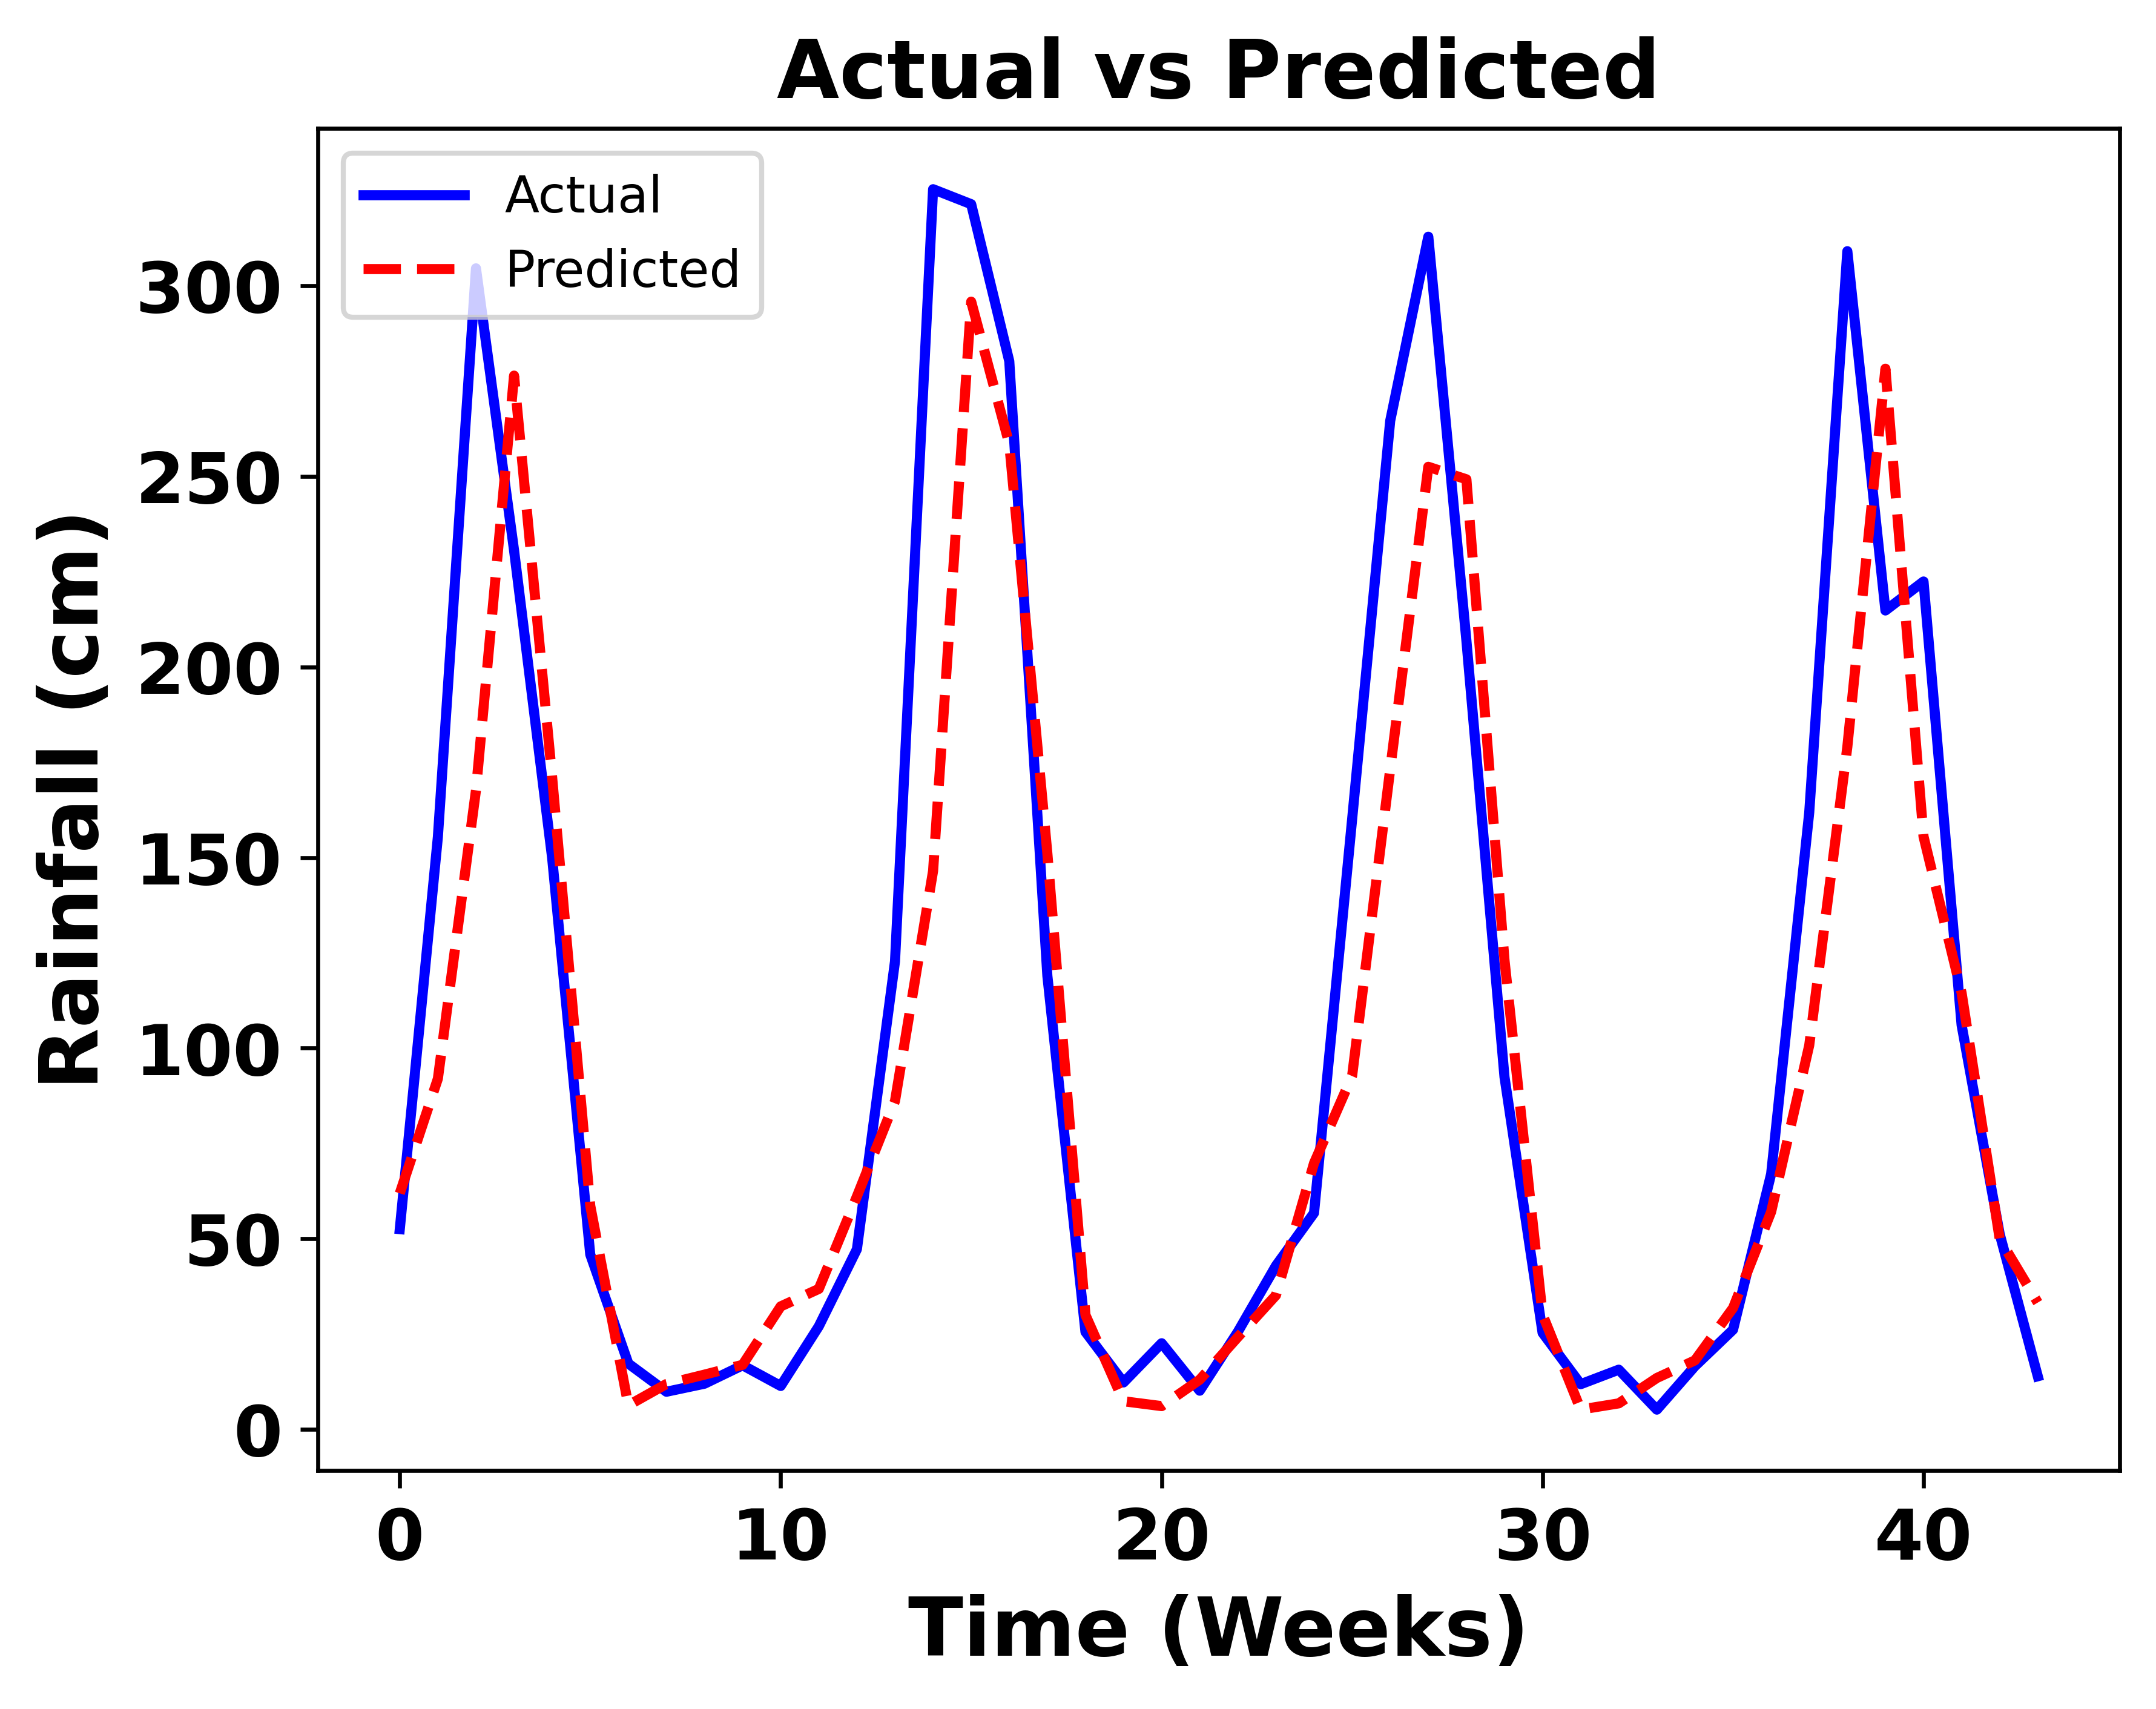

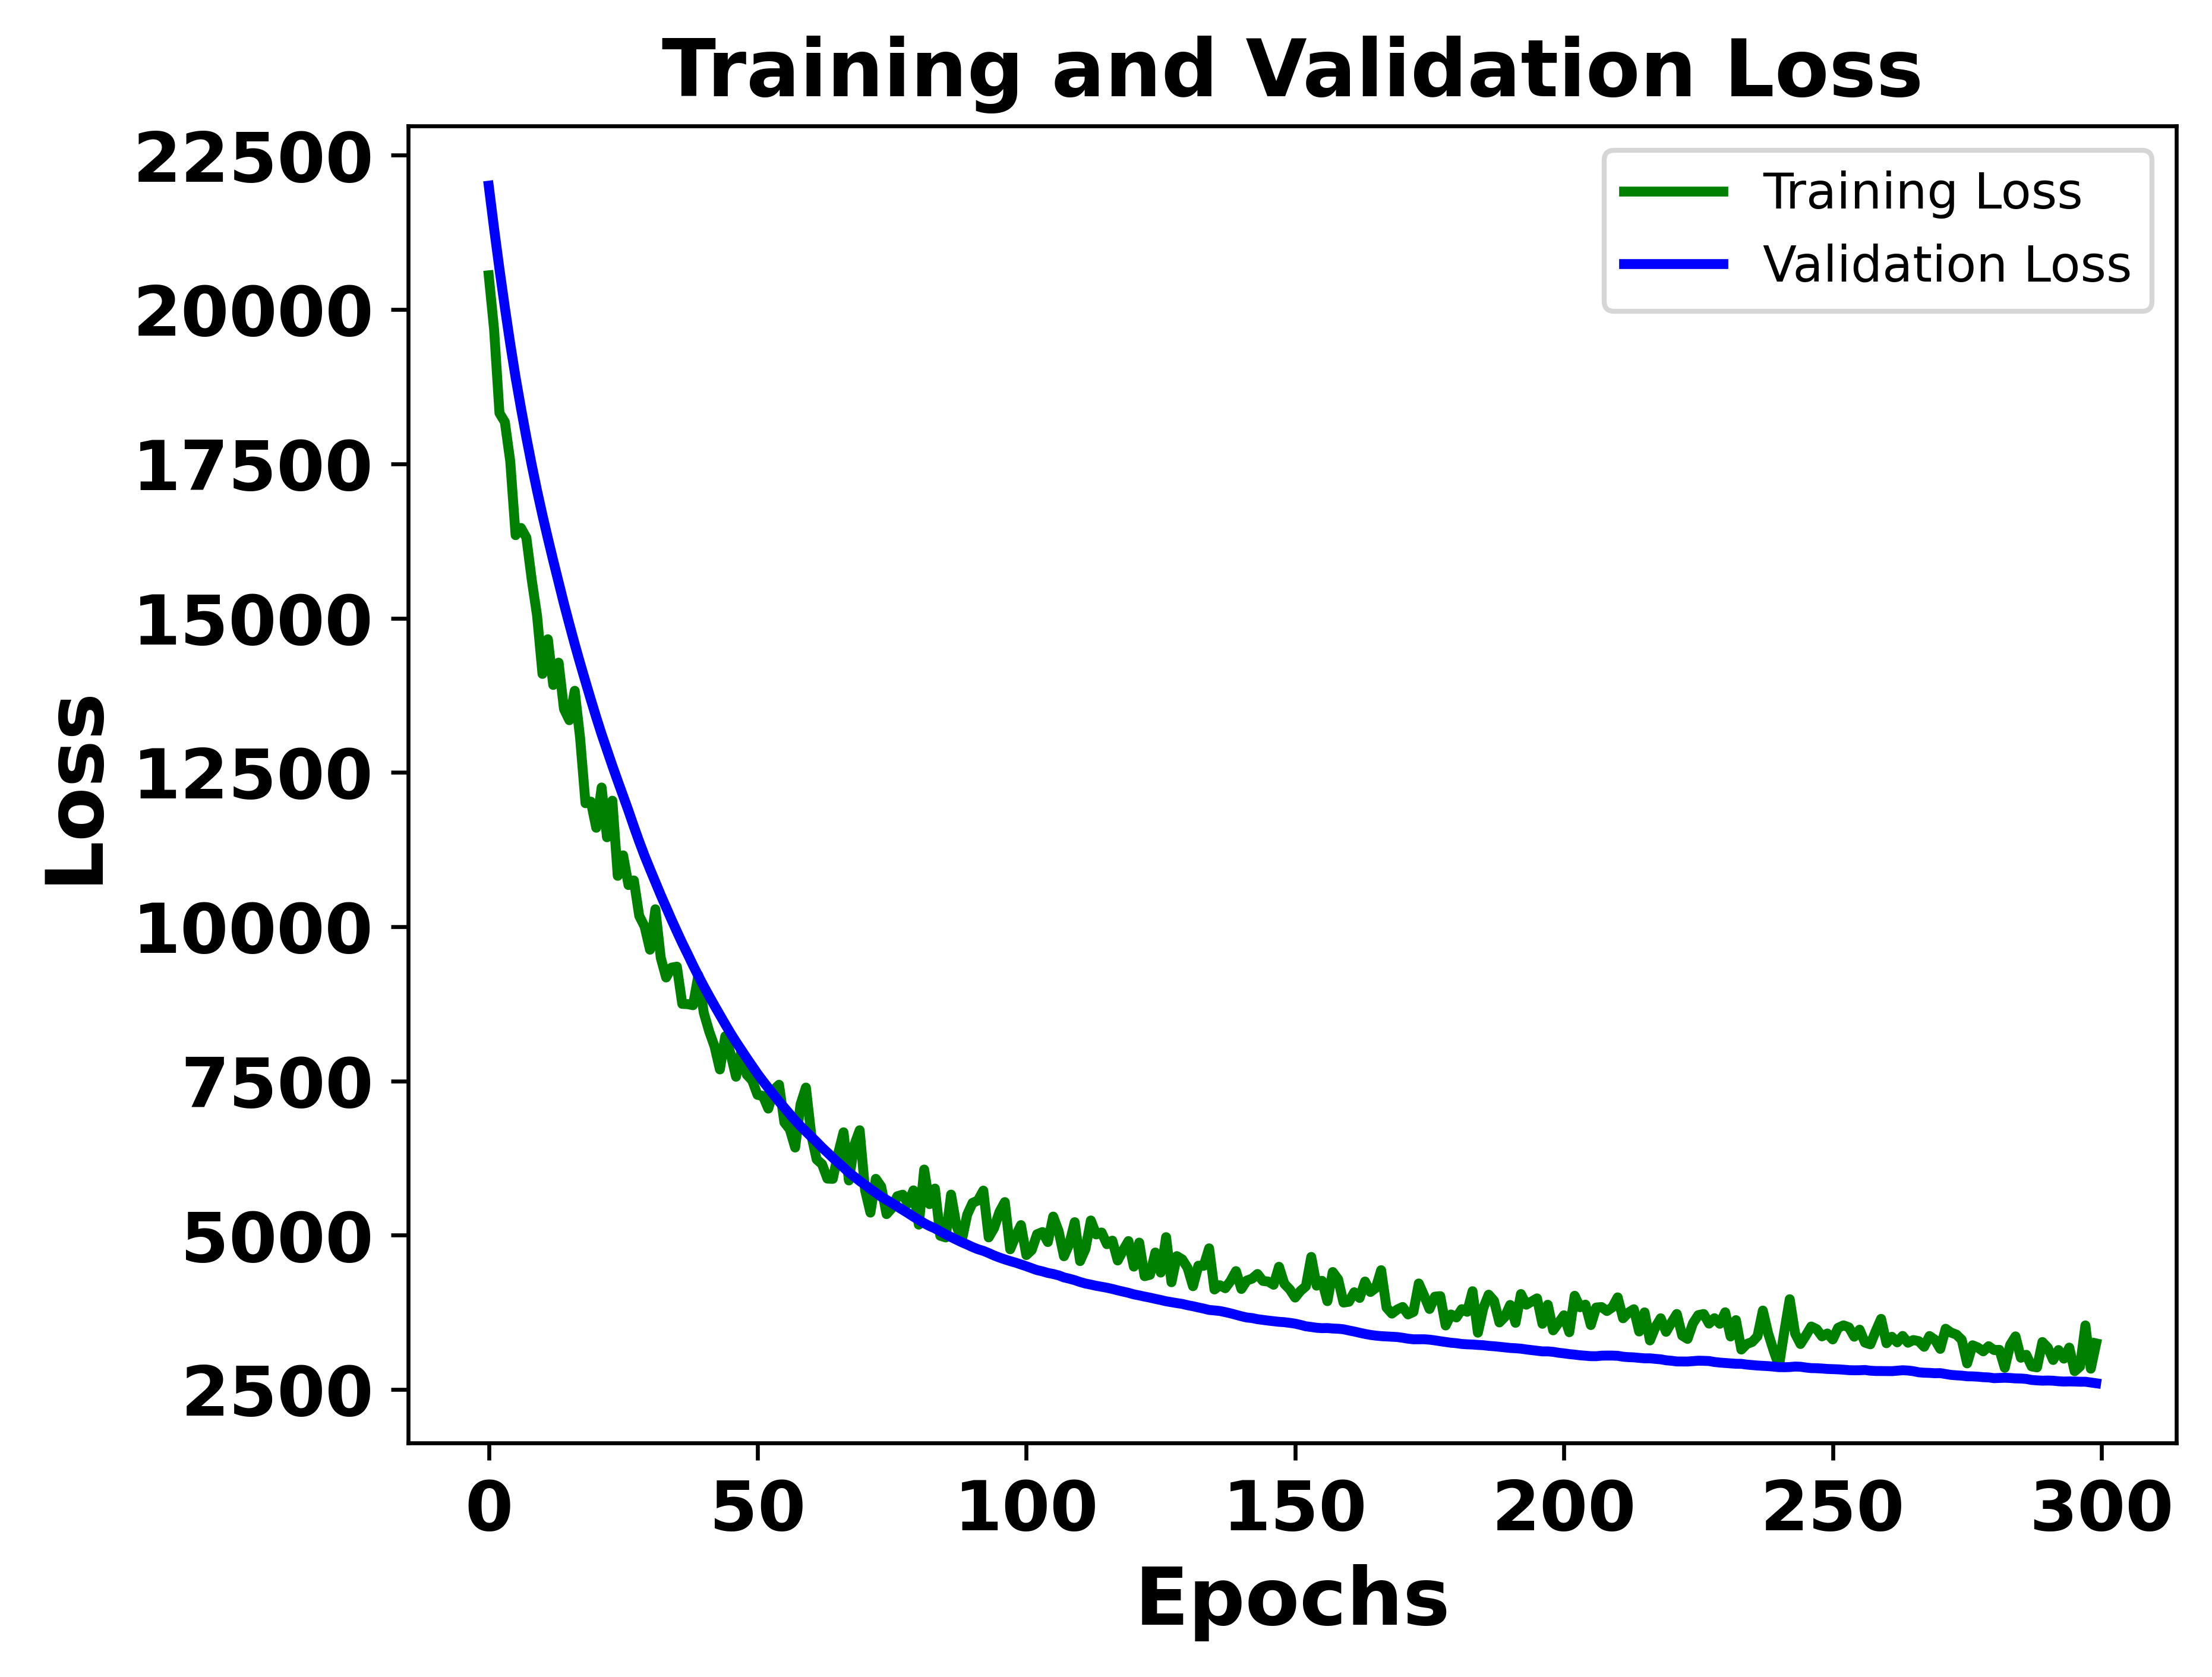

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, callbacks

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

input_shape = x_train.shape[1:]
model = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

# Callbacks
callbacks_list = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# Model Training
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=64,
    callbacks=callbacks_list,
)

# Model Evaluation
test_loss = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Define metric calculation functions
def calculate_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
        "MAPE": metrics.mean_absolute_percentage_error(y_true, y_pred) * 100,
        "MAE": metrics.mean_absolute_error(y_true, y_pred),
        "MSE": metrics.mean_squared_error(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "RRMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)) / np.mean(y_true) * 100,
        "Quantile Loss": np.mean(quantile_loss(0.5, y_true, y_pred))
    }

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def quantile_loss(q, y, f):
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

# Predictions
pred_test = model.predict(x_test)

# Print metrics for test set
metrics_dict_test = calculate_metrics(y_test, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")

# Predictions on training set
pred_train = model.predict(x_train)

# Evaluation metrics for training set
metrics_dict_train = calculate_metrics(y_train, pred_train)
print("\nTraining Set Metrics:")
for metric_name, metric_value in metrics_dict_train.items():
    print(f"Score (Train {metric_name}): {metric_value}")

def plot_actual_vs_predicted(y_true, y_pred, filename):
    plt.figure(dpi=600)
    plt.plot(y_true, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='red', linewidth=2, linestyle='--')
    plt.legend(fontsize='medium', loc='upper left')
    plt.xlabel('Time (Weeks)', fontsize=16, fontweight='bold')
    plt.ylabel('Rainfall (cm)', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.title('Actual vs Predicted', fontsize=16, fontweight='bold')
    plt.savefig(filename, format='jpeg', dpi=600)
    plt.show()

def plot_loss(history, filename):
    plt.figure(dpi=600)
    plt.plot(history.history['loss'], label='Training Loss', color='g', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='b', linewidth=2)
    plt.legend(fontsize='medium', loc='upper right')
    plt.xlabel('Epochs', fontsize=16, fontweight='bold')
    plt.ylabel('Loss', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
    plt.savefig(filename, format='jpeg', dpi=600)
    plt.show()

# Plot Actual vs Predicted for test set
plot_actual_vs_predicted(y_test, pred_test, 'Transformer_predicted_vs_actual.jpeg')

# Plot Training and Validation Loss
plot_loss(history, 'Transformer_loss_plot.jpeg')
